In [5]:
import os
import numpy as np
import pandas as pd
import gensim 
import nltk
from nltk.stem import WordNetLemmatizer
import pyLDAvis
from tqdm import tqdm
from operator import itemgetter
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('trail_1_AI.csv')
num_patents = len(df)
df.head(1)

# Jurisdiction Kind Publication Number              Lens ID  \
0  1           US   B2      US 9600963 B2  007-615-340-149-289   

  Publication Date  Publication Year Application Number Application Date  \
0       21-03-2017            2017.0  US 201615055378 A       26-02-2016   

                                    Priority Numbers  ...  \
0  US 201562171623 P 20150605;;US 201562175380 P ...  ...   

  Extended Family Size Sequence Count                    CPC Classifications  \
0                  2.0            0.0  G07F17/3227;;G07F17/3211;;G07F17/3244   

  IPCR Classifications US Classifications NPL Citation Count  \
0            G07F17/32                NaN                1.0   

  NPL Resolved Citation Count NPL Resolved Lens ID(s)  \
0                         1.0     177-937-456-294-142   

     NPL Resolved External Id(s)  \
0  10.1016/s0004-3702(01)00166-7   

                                       NPL Citations  
0  Brian Sheppard, World-championship-caliber Scr...  

[1 rows x 30 columns]

In [3]:
titles = df['Title']
#abstract = df['abstract']
#claims = df['claims']
text_data = []
for i in range(len(titles)):
    text = str(titles[i])
    # text = str(titles[i]) + str(abstract[i]) + str(claims[i])
    text_data.append(text)

# Basic Text Wrangling

In [4]:
punct = list(string.punctuation)
stop_words = list(nltk.corpus.stopwords.words('english'))
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = WordNetLemmatizer()

patent_stops = 'a, has, such, accordance, have, suitable, according, having, than, all, herein, that, also, however, the, an, if, their, and, in, then, another, into, there, are, invention, thereby, as, is, therefore, at, it, thereof, be, its, thereto, because, means, these, been, not, they, being, now, this, by, of, those, claim, on, thus, comprises, onto, to, corresponding, or, use, could, other, various, described, particularly, was, desired, preferably, were, do, preferred, what, does, present, when, each, provide, where, embodiment, provided, whereby, fig, provides, wherein, figs, relatively, which, for, respectively, while, from, said, who, further, should, will, generally, since, with, had, some, would, first, second, third, fourth, fifth, sixth, seventh, eighth, ninth, tenth, eleventh, twelveth, thtiteenth, least, field, using, applying, based'
patent_stops = patent_stops.split(', ')

patent_stops
stop_words
stop = list(set(patent_stops + stop_words + punct))

In [5]:
def normalize_corpus(patents):
    norm_papers = []
    for text in patents:
        text = text.lower()
        text_tokens = [token.strip() for token in wtk.tokenize(text)]
        text_tokens = [wnl.lemmatize(token) for token in text_tokens if not text.isnumeric()]
        text_tokens = [token for token in text_tokens if len(token) > 1]
        text_tokens = [token for token in text_tokens if token not in stop]
        text_tokens = list(filter(None, text_tokens))
        if text_tokens:
            norm_papers.append(text_tokens)

    return norm_papers

In [6]:
norm_papers = normalize_corpus(text_data)

In [7]:
# viewing a processed paper
print(norm_papers[0])

['gaming', 'machine', 'gaming', 'system', 'gaming', 'method', 'presenting', 'game', 'artificially', 'intelligent', 'player']


# Keyphrase Extaction / Feature Engineering 

Ways to generate phrases with influential bi-grams and remove some terms that may not be useful before feature engineering 

In [8]:
bigram = gensim.models.Phrases(norm_papers, min_count = 20, threshold = 20, delimiter = b'_') # higher threshold fewer words
bigram_model = gensim.models.phrases.Phraser(bigram)

# sample demonstration
print(bigram_model[norm_papers[0][:50]])

['gaming', 'machine', 'gaming', 'system', 'gaming', 'method', 'presenting', 'game', 'artificially_intelligent', 'player']


building vocabulary and from the corpus and filter out word with count < 20 and count > 60%

In [9]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# create a dictionary representation of the documemnts 
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings: ', list(dictionary.items())[:15])
print('Total Vocabulary Size: ', len(dictionary))

Sample word to number mappings:  [(0, 'artificially_intelligent'), (1, 'game'), (2, 'gaming'), (3, 'machine'), (4, 'method'), (5, 'player'), (6, 'presenting'), (7, 'system'), (8, 'apparatus'), (9, 'artificial_intelligence'), (10, 'call'), (11, 'identification'), (12, 'optimization'), (13, 'artificial'), (14, 'autonomous')]
Total Vocabulary Size:  13466


# Text Representation (BOW)

In [10]:
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(4, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


In [11]:
# viewing actual terms and their counts
print([(dictionary[idx], freq) for idx, freq in bow_corpus[1][:50]])

[('method', 1), ('apparatus', 1), ('artificial_intelligence', 1), ('call', 1), ('identification', 1), ('optimization', 1)]


# Topic Modeling (LDA) with hyperparameter tuning to find optimal topics

In [12]:
def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count = 2, end_topic_count = 10, step = 1, cpus = 1):
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count + 1, step)):
        lda_model = gensim.models.LdaMulticore(corpus = corpus, num_topics = topic_nums, id2word = dictionary, iterations = 500, workers = cpus)
        cv_coherence_model_lda = gensim.models.CoherenceModel(model = lda_model, corpus = corpus, texts = texts, dictionary = dictionary,        coherence = 'c_v')
        coherence_score = cv_coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(lda_model)
    return models, coherence_scores

In [34]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus = bow_corpus, texts = norm_corpus_bigrams, dictionary = dictionary, start_topic_count = 2, end_topic_count = 100, step = 1, cpus = 16)

100%|██████████| 99/99 [52:24<00:00, 31.77s/it]


In [49]:
coherence_df = pd.DataFrame({'Number of Topics':range(2, 101, 1), 'Coherence Score':np.round(coherence_scores, 4)})
coherence_df.sort_values(by = ['Coherence Score'], ascending = False)

Number of Topics  Coherence Score
95  97                0.2150         
96  98                0.2104         
98  100               0.2099         
97  99                0.2037         
94  96                0.2026         
..  ..                   ...         
8   10                0.1209         
3   5                 0.1208         
2   4                 0.1112         
0   2                 0.1021         
1   3                 0.0929         

[99 rows x 2 columns]

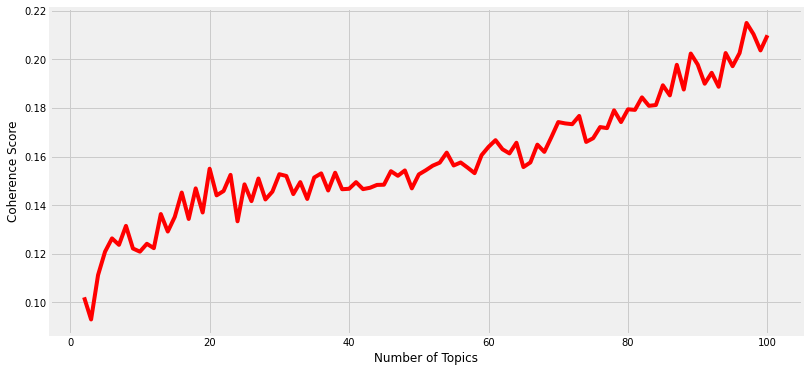

In [51]:
x_ax = range(2, 101, 1)
y_ax = coherence_scores
plt.figure(figsize = (12, 6))
plt.plot(x_ax, y_ax, c = 'r')
# plt.axhline(y = 0.2754, c = 'k', linestyle = '--', linewidth = 2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [52]:
best_model_idx = coherence_df[coherence_df['Coherence Score'] == max(coherence_df['Coherence Score'])].index[0]
best_lda_model = lda_models[best_model_idx]

In [53]:
topics = [[(term, round(wt, 3)) for term, wt in best_lda_model.show_topic(n, topn = 30)] for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #' + str(idx + 1) + ":")
    print([(term, round(wt, 3)) for term, wt in topic])
    print()

Topic #1:
[('method', 0.068), ('system', 0.063), ('device', 0.024), ('providing', 0.012), ('apparatus', 0.011), ('information', 0.009), ('network', 0.008), ('user', 0.008), ('control', 0.008), ('electronic', 0.008), ('data', 0.007), ('game', 0.005), ('related', 0.005), ('dynamic', 0.005), ('service', 0.005), ('generating', 0.004), ('analysis', 0.004), ('content', 0.004), ('camera', 0.004), ('medium', 0.004), ('model', 0.004), ('machine', 0.004), ('estimation', 0.004), ('integrated', 0.004), ('video', 0.004), ('multi', 0.003), ('access', 0.003), ('wireless', 0.003), ('enhanced', 0.003), ('program', 0.003)]

Topic #2:
[('system', 0.036), ('method', 0.032), ('user', 0.012), ('information', 0.012), ('document', 0.009), ('generation', 0.009), ('data', 0.009), ('analysis', 0.009), ('apparatus', 0.008), ('digital', 0.008), ('device', 0.007), ('search', 0.006), ('automated', 0.006), ('image', 0.006), ('content', 0.005), ('automatic', 0.005), ('object', 0.005), ('level', 0.005), ('robot', 0.004

In [54]:
#topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index = ['Topic'+str(t) for t in range(1, best_lda_model.num_topics + 1)]).T

#topics_df

In [55]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topics'], index = ['Topic'+str(t) for t in range(1, best_lda_model.num_topics + 1)])

In [56]:
lda_corpus = best_lda_model[bow_corpus] 
topics_distribution = {}
for i in lda_corpus:
    res = max(i, key = itemgetter(1))[0]
    res = res + 1
    if res in topics_distribution.keys():
        topics_distribution[res] += 1
    else:
        topics_distribution[res] = 1

In [58]:
num_topics = best_lda_model.num_topics
num_topics

97

In [59]:
num_topics = best_lda_model.num_topics
threshold_low = (num_patents / num_topics)// 1.3
threshold_high = (num_patents // num_topics)*1.5
hotspots = []
vacuume = []
for i in topics_distribution.keys():
    if topics_distribution[i] >= threshold_high:
        hotspots.append(i)
    elif topics_distribution[i] < threshold_low:
        vacuume.append(i)

Hotspot for Topic 1: 


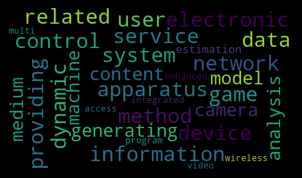

Hotspot for Topic 17: 


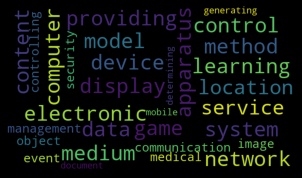

Hotspot for Topic 24: 


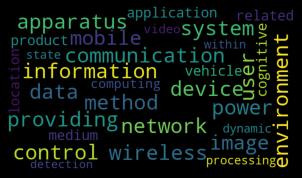

Hotspot for Topic 41: 


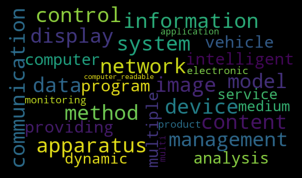

Hotspot for Topic 55: 


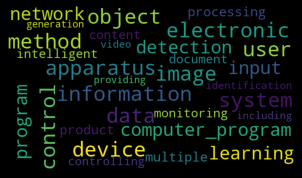

Hotspot for Topic 85: 


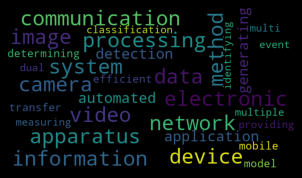

In [60]:
# Hotspots
for i in sorted(hotspots):
    key = 'Topic'+str(i)
    words = topics_df.iloc[i-1][0].split(', ')
    print(f'Hotspot for Topic {i}: ')
    comment_words = '' 
    comment_words += " ".join(words)+" "
    wordcloud = WordCloud(max_font_size=50, width = 700, height = 400, 
                background_color ='black', 
                stopwords = stop, 
                min_font_size = 10).generate(comment_words)
    plt.figure(figsize = (4, 4), facecolor = 'black') 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

Vacuum for Topic 4: 


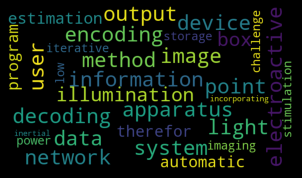

Vacuum for Topic 14: 


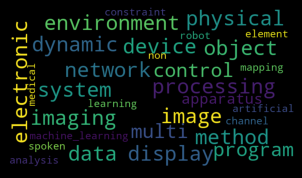

Vacuum for Topic 15: 


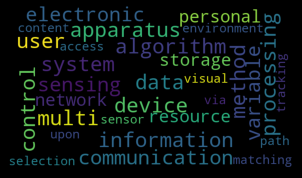

Vacuum for Topic 19: 


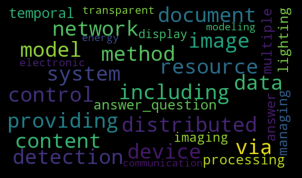

Vacuum for Topic 21: 


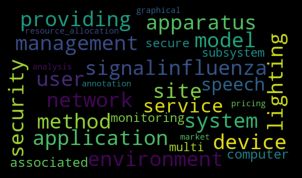

Vacuum for Topic 34: 


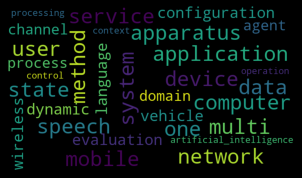

Vacuum for Topic 36: 


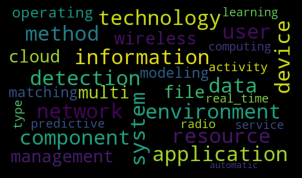

Vacuum for Topic 43: 


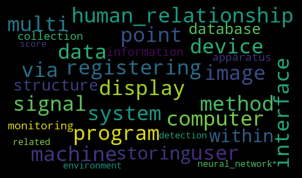

Vacuum for Topic 48: 


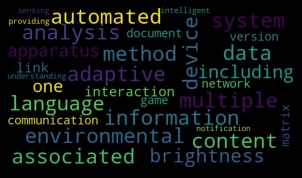

Vacuum for Topic 52: 


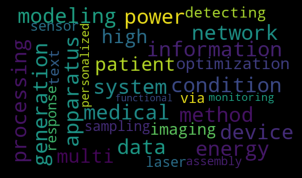

Vacuum for Topic 63: 


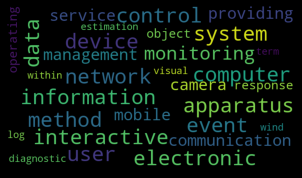

Vacuum for Topic 69: 


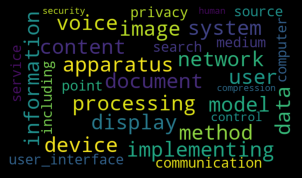

Vacuum for Topic 72: 


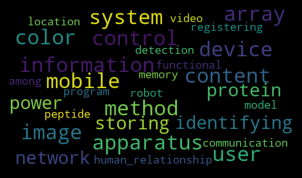

Vacuum for Topic 73: 


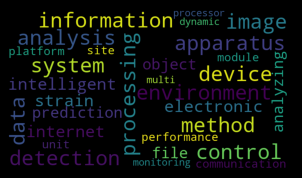

Vacuum for Topic 82: 


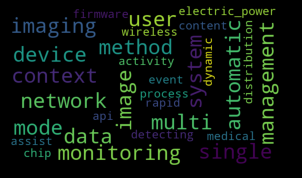

Vacuum for Topic 90: 


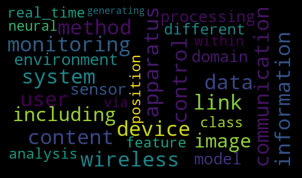

Vacuum for Topic 92: 


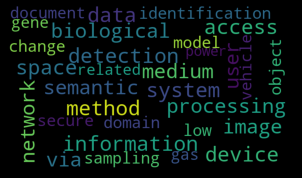

Vacuum for Topic 94: 


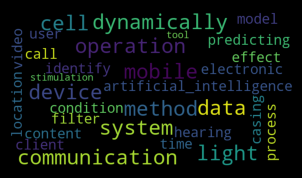

Vacuum for Topic 96: 


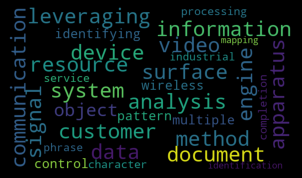

Vacuum for Topic 97: 


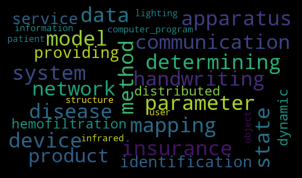

In [61]:
# Vacuume
for i in sorted(vacuume):
    key = 'Topic'+str(i)
    words = topics_df.iloc[i-1][0].split(', ')
    print(f'Vacuum for Topic {i}: ')
    comment_words = '' 
    comment_words += " ".join(words)+" "
    wordcloud = WordCloud(max_font_size=50, width = 700, height = 400, 
                background_color ='black', 
                stopwords = stop, 
                min_font_size = 10).generate(comment_words)
    plt.figure(figsize = (4, 4), facecolor = 'black') 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

# Visualizing the Topics

In [62]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [63]:
#lda_model = gensim.models.LdaMulticore(corpus = bow_corpus, num_topics = 15, id2word = dictionary, iterations = 500, workers = 16)
pyLDAvis.gensim.prepare(best_lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
54     0.092013 -0.020897  1       1        1.954192
23     0.074741  0.043261  2       1        1.642467
40     0.093323  0.018490  3       1        1.557187
84     0.067627 -0.023094  4       1        1.515741
16     0.058091  0.003270  5       1        1.513871
...         ...       ... ..      ..             ...
89    -0.042115  0.024277  93      1        0.727487
81    -0.123762 -0.038735  94      1        0.725669
95    -0.100292 -0.033025  95      1        0.681314
47    -0.116677  0.039501  96      1        0.644123
3     -0.161664 -0.063333  97      1        0.581207

[97 rows x 5 columns], topic_info=           Term         Freq        Total Category  logprob  loglift
80   image       2514.000000  2514.000000  Default  30.0000  30.0000
54   data        3938.000000  3938.000000  Default  29.0000  29.0000
159  processing  1966.000000  1966.000000  Default  28.0000  28.0000
8    apparatus   3461.000000  3461.000000  Default  27.0000  27.0000
30   device      4970.000000  4970.000000  Default  26.0000  26.0000
..      ...              ...          ...      ...      ...      ...
280  storage     7.147720     369.055939   Topic97 -5.5224   1.2037 
147  network     8.939053     2260.815430  Topic97 -5.2987  -0.3852 
469  pattern     6.563705     251.273178   Topic97 -5.6076   1.5028 
249  power       6.846052     524.735046   Topic97 -5.5655   0.8086 
767  imaging     6.573149     405.967529   Topic97 -5.6062   1.0245 

[7330 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
1948   27     0.354133  1129 
1948   74     0.354133  1129 
9458   24     0.576964  12   
5520   31     0.409962  1st  
12283  73     0.449691  200  
...    ..          ...  ...  
7659   13     0.431611  zinc 
6652   32     0.576726  zonal
1820   6      0.380680  zoom 
1820   26     0.380680  zoom 
11253  3      0.484700  zucc 

[35020 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[55, 24, 41, 85, 17, 59, 49, 74, 83, 37, 66, 42, 45, 12, 7, 47, 60, 65, 26, 79, 13, 23, 11, 6, 9, 87, 95, 1, 91, 67, 84, 68, 27, 35, 71, 75, 53, 46, 40, 58, 22, 80, 86, 57, 10, 20, 77, 29, 18, 78, 2, 76, 89, 25, 61, 88, 33, 44, 93, 64, 8, 50, 62, 39, 28, 38, 31, 54, 51, 30, 5, 56, 72, 3, 32, 70, 16, 81, 52, 34, 21, 94, 14, 36, 43, 19, 63, 69, 97, 15, 92, 73, 90, 82, 96, 48, 4])

In [1]:
import ContentAnalysis_v1

100%|██████████| 29/29 [20:04<00:00, 41.55s/it]
Vacuum for Topic 4: 


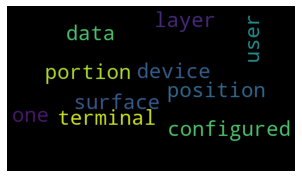

Vacuum for Topic 5: 


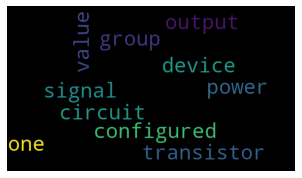

In [2]:
best_lda_model, bow_corpus, dictionary = ContentAnalysis_v1.topics('ipa200409_v1.csv', claims_abstract = True, min_count_keywords = 20, threshold_keywords = 20, min_topics = 2, max_topics = 30, cpus = 16, topn_words_per_topic = 10, topic_vis = True)

In [7]:
pyLDAvis.gensim.prepare(best_lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.024294  0.033124       1        1  14.263865
7      0.024318 -0.000454       2        1  11.823574
0      0.006307  0.000523       3        1  10.008815
10    -0.041048  0.019068       4        1   9.869662
8      0.079880 -0.041605       5        1   9.727881
9      0.060580 -0.030052       6        1   9.013848
6      0.009783 -0.020603       7        1   8.528186
5     -0.013524  0.052547       8        1   8.524682
1     -0.018895  0.026457       9        1   7.086261
3      0.012667  0.040722      10        1   5.605831
4     -0.095772 -0.079725      11        1   5.547397, topic_info=             Term          Freq         Total Category  logprob  loglift
869         layer   8820.000000   8820.000000  Default  30.0000  30.0000
323        signal  10784.000000  10784.000000  Default  29.0000  29.0000
18         device  19318.000000  19318.000000  Default  28.0000  28.0000
293          data  17178.000000  17178.000000  Default  27.0000  27.0000
1463        group   3349.000000   3349.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
896   information    326.736176   8657.934570  Topic11  -5.5863  -0.3852
78         system    290.112793   8263.349609  Topic11  -5.7052  -0.4575
1607     terminal    258.186920   3195.291260  Topic11  -5.8218   0.3761
15     comprising    274.224579   7095.000488  Topic11  -5.7615  -0.3614
216           set    268.121460   5880.419922  Topic11  -5.7840  -0.1961

[930 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
15616      6  0.971939        100_sequence
15616     11  0.022090        100_sequence
8428       1  0.960925             140_seq
8428       8  0.028828             140_seq
8430       1  0.969378              30_140
...      ...       ...                 ...
8043       5  0.137103       yl_oxaborolan
8043      10  0.636550       yl_oxaborolan
13701      5  0.980771  yl_picolinonitrile
12695      3  0.097667         zigzag_path
12695      6  0.879003         zigzag_path

[2835 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 1, 11, 9, 10, 7, 6, 2, 4, 5])